In [1]:

from monai.inferers import sliding_window_inference
import matplotlib.pyplot as plt
import numpy as np
from monai.transforms import Compose, Invertd, SaveImaged
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
import torch
import json


In [8]:
config_file = 'config.json'

with open(config_file, 'r') as f:
    config = json.load(f)

ga_data_dir = config["ga_data_dir"]
fdg_data_dir = config["fdg_data_dir"]
log_dir = config["log_dir"]
ga_output_dir = config["ga_output_dir"]
# artifact_dir = config["artifacts"]
# artifact_output = config ["artifact_output"]
fdg_output_dir = config['fdg_output_dir']


---------------------
# FDG :


In [ ]:
# from data_preparation import ExtrenalRadioSetSetHandling

# data_handler = ExtrenalRadioSetSetHandling(fdg_data_dir, train_mode="NAC", target_mode="MAC")

# test_files = data_handler.get_data()
# print(len(test_files))


In [9]:
# FDG
from data_preparation import ExternalRadioSetHandling, LoaderFactory

data_handler = ExternalRadioSetHandling(data_dir=fdg_data_dir, test_ratio=0.2)
train_files, val_files, test_files = data_handler.get_split_data()

print(f"Test data length: {len(test_files)}")
print(f"Validation data length: {len(val_files)}")
print(f"Train data length: {len(train_files)}")


loader_factory = LoaderFactory(
    train_files=None,
    val_files=None,
    test_files=test_files,
    patch_size = [168, 168, 16],
    spacing = [4.07, 4.07, 3.00],
    # spacing = [1.92, 1.92, 3.27], # For fdg data
    # spatial_size = (168, 168, 400)
    # spatial_size = (336, 336, 640) # for Fdg data
    spatial_size = (168, 168, 600) # for Fdg data
    )

test_loader = loader_factory.get_loader('test', batch_size=1, num_workers=2, shuffle=False)

Test data length: 21
Validation data length: 15
Train data length: 62


------------------
# Ga

In [ ]:
from data_preparation import DataHandling 

data_handler = DataHandling(ga_data_dir, train_mode="NAC", target_mode="ADCM")

train_files = data_handler.get_data_split('train')
val_files = data_handler.get_data_split('val')
test_files = data_handler.get_data_split('test')
print(len(train_files))
print(len(val_files))
print(len(test_files))

from data_preparation import LoaderFactory
loader_factory = LoaderFactory(
    train_files=train_files,
    val_files=val_files,
    test_files=test_files,
    patch_size = [168, 168, 16],
    spacing = [4.07, 4.07, 3.00],
    # spacing = [1.92, 1.92, 3.27], # For fdg data
    spatial_size = (168, 168, 320)
    # spatial_size = (336, 336, 640) # for Fdg data
    )

test_loader = loader_factory.get_loader('test', batch_size=1, num_workers=2, shuffle=False)
val_loader = loader_factory.get_loader('val', batch_size=1, num_workers=2, shuffle=False)



----------
# loading model

In [10]:
from utils import find_last_saved_model, parse_loss_values

# log_filename = 'log_2_26_8_17.txt' # saved on hard
# log_filename = 'log_3_4_12_4.txt' # saved on hard
# log_filename = 'log_3_4_12_41.txt' # saved on hard
# log_filename = 'log_3_18.txt'
log_filename = 'log_3_27_8_47.txt' # Tuned for fdg
# log_filename = 'log_3_28_6_8.txt'
# log_filename = 'log_3_28_10_41.txt'
# log_filename = 'log_3_28_20_48.txt' # Tuned for itself on ga
# log_filename = 'log_3_29_6_54.txt' # adcm final model for 11 april is here
log_filename = 'log_4_6_8_55.txt' # Ghabl az relu gozashtan hast, structure fargh dare.
# log_filename = 'log_4_12_23_41.txt' # adcm structure modelesh fargh dare yadam nist male chie ghaziash
# log_filename = 'log_4_13_11_32.txt' # adcm norm 100
log_filename = 'log_4_26_21_24.txt' # adcm norm 50

log_filepath = log_dir + '/'+ log_filename
bestmodel_filename, best_metric, best_epoch = find_last_saved_model(log_filepath)
print(f"Model Filename: {bestmodel_filename}, Best Metric: {best_metric}, Epoch: {best_epoch}")


Model Filename: model_5_2_14_27.pth, Best Metric: 0.1237, Epoch: 466


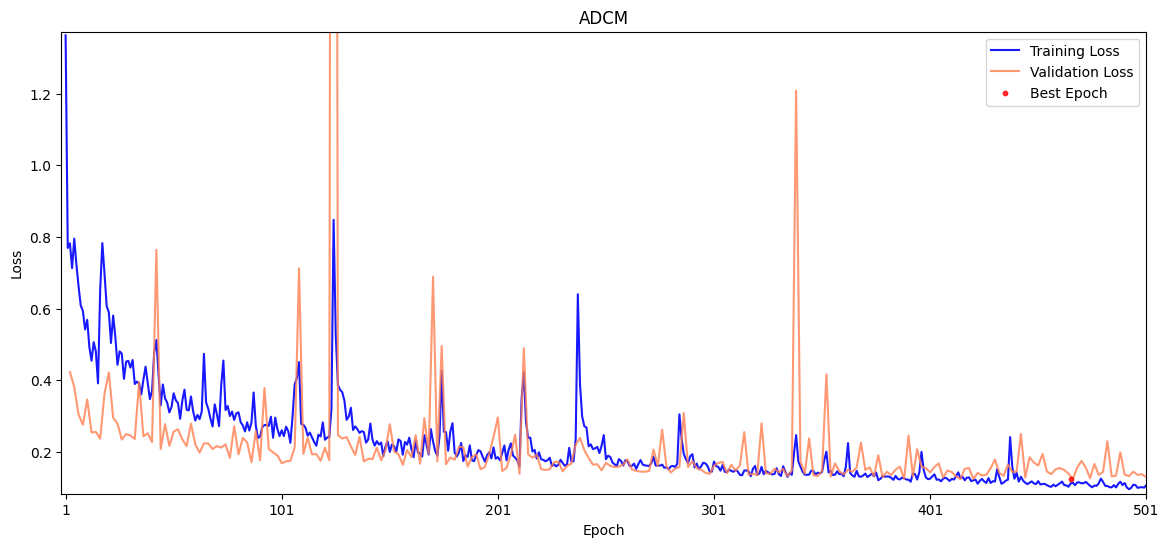

In [37]:
import matplotlib.pyplot as plt
import numpy as np



train_losses, val_losses = parse_loss_values(log_filepath)

max_epochs = len(train_losses)
start_epoch = 1  # Can be set to any valid epoch number, including 1
val_interval = 2  # Update this if your validation interval is different

# Ensure start_epoch is within the range of available data
start_epoch = max(1, min(start_epoch, max_epochs))

# Calculate the range of epochs for training and validation
epochs = range(start_epoch, max_epochs + 1)
val_epochs = range(start_epoch + val_interval - ((start_epoch - 1) % val_interval), max_epochs + 1, val_interval)

# Adjust the indices for slicing based on the starting epoch
train_idx = start_epoch - 1
val_idx = (start_epoch - 1) // val_interval

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(epochs, train_losses[train_idx:], label='Training Loss', color='blue', alpha=0.9)
if len(val_epochs) > 0 and val_idx < len(val_losses):
    plt.plot(val_epochs, val_losses[val_idx:val_idx+len(val_epochs)], label='Validation Loss', color='coral', alpha=0.8)
best_val_loss = val_losses[best_epoch // val_interval - 1]  # Example best validation loss
plt.scatter(best_epoch, best_val_loss, color='red', s=10, label='Best Epoch', zorder=5, alpha = 0.8)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ADCM')
plt.legend()
plt.xlim(-1, 20) #max_epochs + 1)  # Adjust the x-axis start and end points
plt.ylim(min(train_losses+val_losses)-0.01, max(train_losses)+0.01)  # Adjust y-axis to start slightly below min loss value

plt.xticks(np.arange(start_epoch, max_epochs + 1, 100))  # Adjust the x-axis ticks if needed
plt.show()

In [11]:
import os
import torch
from model_maker import get_network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_network(patch_size = [168, 168, 16], spacing = [4.07, 4.07, 3.00])

model = model.to(device)


DyUnet is set:
Kernel size:  [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
Strides:  [[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 1]]


In [12]:
import torch.nn as nn
def add_activation_before_output(model, activation_fn):
    """
    Adds an activation function just before the output of the network.
    """
    # Replace the last conv layer with a sequential layer that has conv followed by activation
    old_output_conv = model.output_block.conv.conv
    new_output_block = nn.Sequential(
        old_output_conv,
        activation_fn
    )
    model.output_block.conv.conv = new_output_block

# Assuming 'model' is your DynUNet model instance
# Replace 'nn.ReLU(inplace=True)' with the activation function you want to use.
add_activation_before_output(model, nn.ReLU(inplace=True))

In [13]:
import torch

# Assuming root_dir is the directory where your model files are stored
model_path = os.path.join(log_dir, bestmodel_filename)
if os.path.exists(model_path):
    print(f"Model file {bestmodel_filename} is loading.")
    model.load_state_dict(torch.load(model_path))
    model.eval()
else:
    print(f"Model file {bestmodel_filename} not found.")

Model file model_5_2_14_27.pth is loading.


In [14]:
# Extract file names
test_name = [(os.path.splitext(os.path.basename(file_info['image']))[0], os.path.splitext(os.path.basename(file_info['target']))[0]) for file_info in test_files]
test_name


[('006006_dataset_07_A.nii', '006006_dataset_07_A.nii'),
 ('006010_dataset_07_A.nii', '006010_dataset_07_A.nii'),
 ('006051_dataset_07_A.nii', '006051_dataset_07_A.nii'),
 ('005073_dataset_06_A.nii', '005073_dataset_06_A.nii'),
 ('005060_dataset_06_A_nac_6.nii', '005060_dataset_06_A_nac_6.nii'),
 ('005002_dataset_06_A_nac_6.nii', '005002_dataset_06_A_nac_6.nii'),
 ('005106_dataset_06_A.nii', '005106_dataset_06_A.nii'),
 ('005039_dataset_06_A.nii', '005039_dataset_06_A.nii'),
 ('005005_dataset_06_A.nii', '005005_dataset_06_A.nii'),
 ('005043_dataset_06_A_nac_3.nii', '005043_dataset_06_A_nac_3.nii'),
 ('006044_dataset_07_A.nii', '006044_dataset_07_A.nii'),
 ('006046_dataset_07_A.nii', '006046_dataset_07_A.nii'),
 ('006024_dataset_07_A.nii', '006024_dataset_07_A.nii'),
 ('006041_dataset_07_A.nii', '006041_dataset_07_A.nii'),
 ('006037_dataset_07_A.nii', '006037_dataset_07_A.nii'),
 ('005037_dataset_06_A.nii', '005037_dataset_06_A.nii'),
 ('006007_dataset_07_A.nii', '006007_dataset_07_A.ni

------
# Inference ADCM

100%|██████████| 10/10 [00:58<00:00,  5.86s/it]


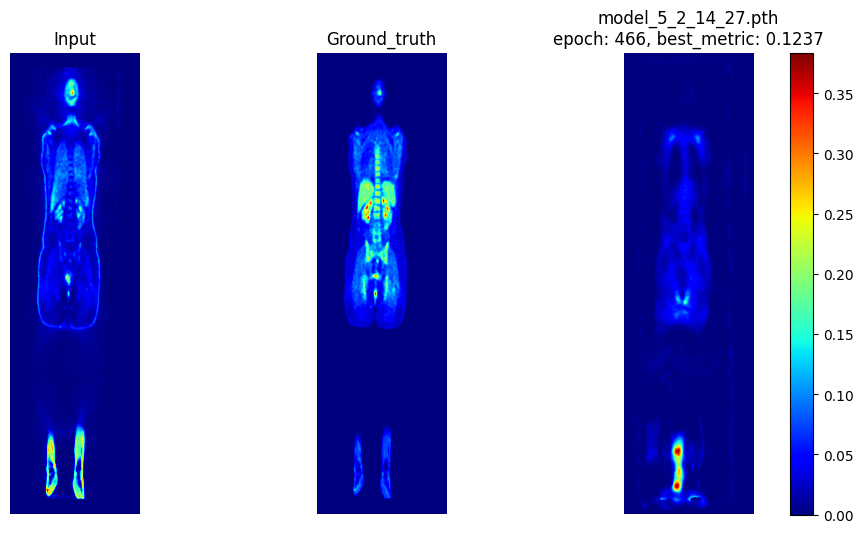

In [16]:
import torch
from vis import model_visualize_coronal

# spatial_size = (336, 336, 640)
roi_size = (168, 168, 16)
# roi_size = (336, 336, 32)

sw_batch_size = 64
slice_number = 100

with torch.no_grad():
    for i, data in enumerate(test_loader):

        predict = sliding_window_inference(data["image"].to(device), roi_size,
                          sw_batch_size, model, progress=True, overlap=0.90)
        
        model_visualize_coronal(data, predict, slice_number, 
                                f"{bestmodel_filename}\nepoch: {best_epoch}, best_metric: {best_metric}", 
                                "jet", Norm=False)
        if i == 0:
            break


-------------
# Export ADCM

In [29]:

from monai.transforms import Compose
from data_preparation import ClampNegative


roi_size = (168, 168, 16)
sw_batch_size = 64


post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=loader_factory.get_test_transforms(),
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        # ClampNegative(keys=["pred"]),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir=fdg_output_dir, output_postfix="adcm_4_26", resample=False), 
    ]
)

with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model, overlap=0.90)
        post_processed = [post_transforms(i) for i in decollate_batch(test_data)]
        
# "adcm_4_26" both fdg and ga on their directory

2024-05-05 08:47:42,627 INFO image_writer.py:197 - writing: /students/2023-2024/master/Shahpouri/FDG_OUTPUT/006006_dataset_07_A/006006_dataset_07_A_adcm_4_26.nii.gz
2024-05-05 08:49:46,541 INFO image_writer.py:197 - writing: /students/2023-2024/master/Shahpouri/FDG_OUTPUT/006010_dataset_07_A/006010_dataset_07_A_adcm_4_26.nii.gz
2024-05-05 08:51:44,612 INFO image_writer.py:197 - writing: /students/2023-2024/master/Shahpouri/FDG_OUTPUT/006051_dataset_07_A/006051_dataset_07_A_adcm_4_26.nii.gz
2024-05-05 08:53:46,696 INFO image_writer.py:197 - writing: /students/2023-2024/master/Shahpouri/FDG_OUTPUT/005073_dataset_06_A/005073_dataset_06_A_adcm_4_26.nii.gz
2024-05-05 08:55:46,790 INFO image_writer.py:197 - writing: /students/2023-2024/master/Shahpouri/FDG_OUTPUT/005060_dataset_06_A_nac_6/005060_dataset_06_A_nac_6_adcm_4_26.nii.gz
2024-05-05 08:57:43,811 INFO image_writer.py:197 - writing: /students/2023-2024/master/Shahpouri/FDG_OUTPUT/005002_dataset_06_A_nac_6/005002_dataset_06_A_nac_6_adc

----------
# Export DL_Final in SUV unit

In [14]:
import os
import glob
import nibabel as nib
from vis import plot_adcm_final_coronal, plot_adcm_final_trans
from utils import calculate_dl_mac, extract_id


In [30]:
def calculate_dl_mac(nac_img, dl_adcm_img, nac_factor, mac_factor, val):

    dl_adcm_img = dl_adcm_img * val
    nac_img = nac_img * nac_factor
    
    dl_final = np.copy(nac_img)
    
    # Only perform division where NASC-PET is greater than epsilon
    mask = nac_img > 0
    dl_final[mask] = (dl_adcm_img[mask] * nac_img[mask]) / mac_factor
    
    return dl_final

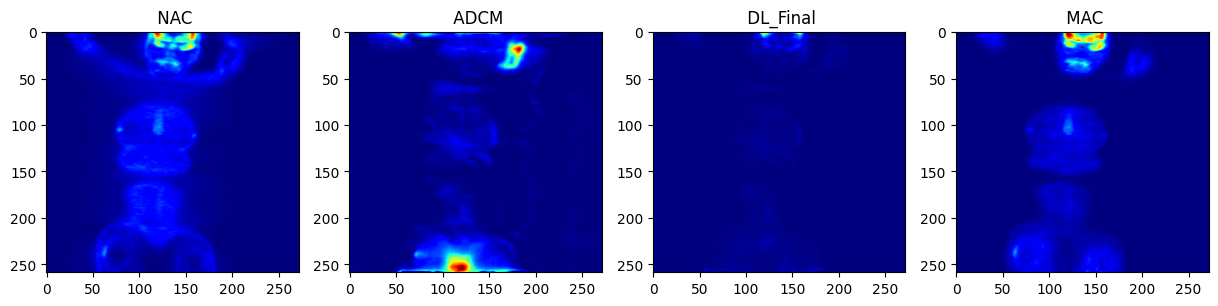

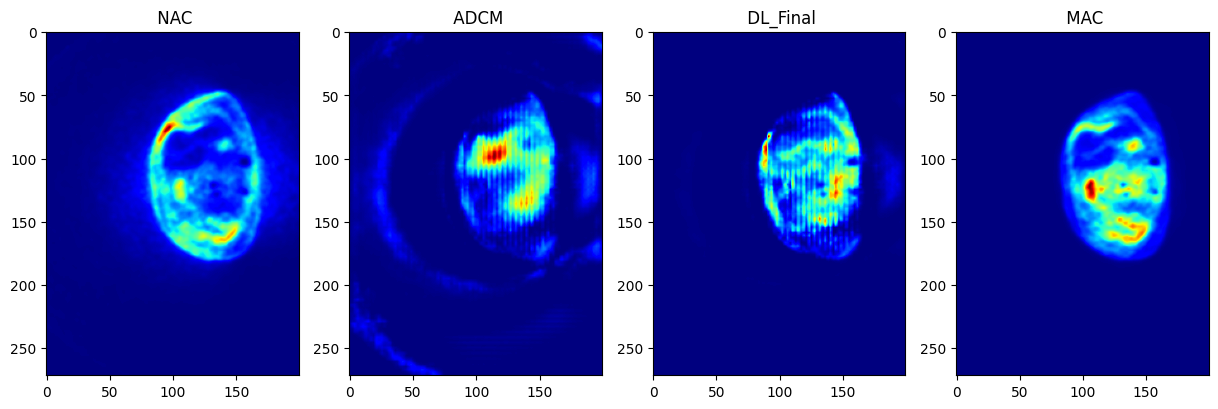

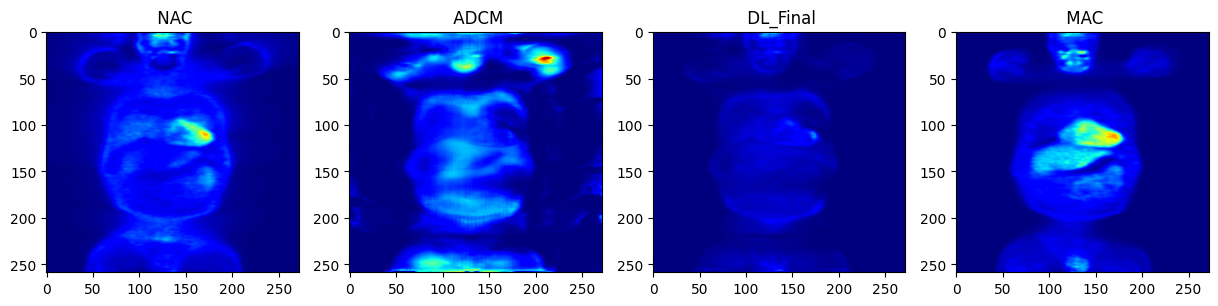

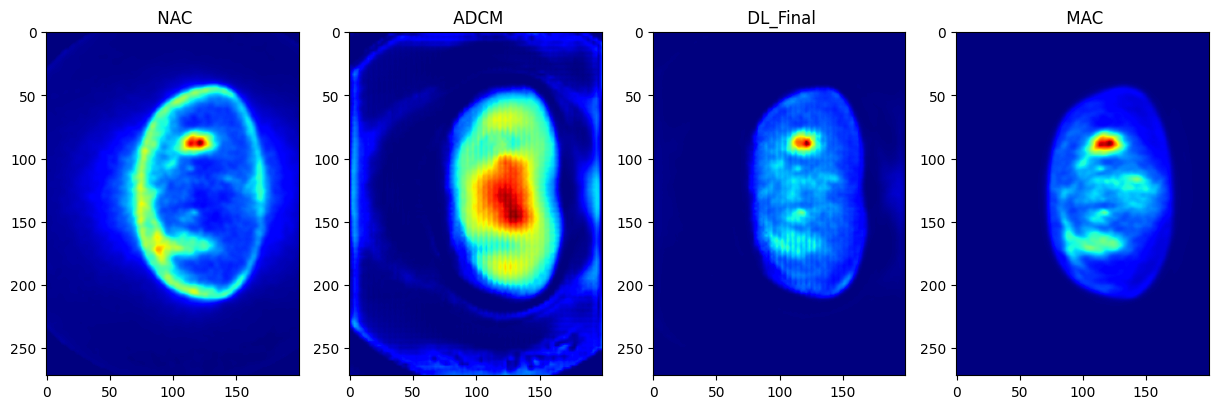

In [33]:
# hint = 'dl_adcm_3_29_v2'
hint_in = 'adcm_4_26'
hint_out = '_final_4_26'

nac_factor = 3 # for fdg data
mac_factor = 9 # for fdg data

# nac_factor = 2 # for ga data
# mac_factor = 5 # for ga data

val = 50

nac_images = sorted(glob.glob(os.path.join(fdg_data_dir, "NAC", "*.nii.gz")))
mac_images = sorted(glob.glob(os.path.join(fdg_data_dir, "MAC", "*.nii.gz")))
dl_adcm_images = sorted(glob.glob(os.path.join(fdg_output_dir, f'**/*{hint_in}.nii.gz'), recursive=True))

# Create a dictionary to map identifiers to DL ADCM image paths
dl_adcm_dict = {extract_id(filepath): filepath for filepath in dl_adcm_images}
mac_dict = {extract_id(filepath): filepath for filepath in mac_images}

# Create pairs by matching the NAC image identifiers with those in the DL ADCM and MAC dictionaries
paired_images = [(nac_img, dl_adcm_dict[extract_id(nac_img)], mac_dict[extract_id(nac_img)]) for nac_img in nac_images if extract_id(nac_img) in dl_adcm_dict]


i = 0
for nac_path, dl_adcm_path, mac_path in paired_images:
    nac_nii = nib.load(nac_path)
    nac_img = nac_nii.get_fdata()
    
    mac_nii = nib.load(mac_path)
    mac_img = mac_nii.get_fdata()


    dl_adcm_nii = nib.load(dl_adcm_path)
    dl_adcm_im = dl_adcm_nii.get_fdata()
    
    dl_final = calculate_dl_mac(nac_img, dl_adcm_im, nac_factor, mac_factor, val)
    
    # Plotting the middle slice from the NAC, MAC, and ADCM images
    plot_adcm_final_coronal(nac_img, dl_adcm_im, dl_final, mac_img, n=85, title_prefix="")
    plot_adcm_final_trans(nac_img, dl_adcm_im, dl_final, mac_img, title_prefix="")
    i += 1
    if i == 2:
        break

In [34]:
from utils import export_final_adcm_image
for nac_path, dl_adcm_path, mac_path in paired_images:
    nac_nii = nib.load(nac_path)
    nac_img = nac_nii.get_fdata()
    
    mac_nii = nib.load(mac_path)
    mac_img = mac_nii.get_fdata()
    print(mac_img.max())
    dl_adcm_nii = nib.load(dl_adcm_path)
    dl_adcm_img = dl_adcm_nii.get_fdata()
    
    dl_final_img = calculate_dl_mac(nac_img, dl_adcm_img, nac_factor, mac_factor, val)
    print(dl_final_img.max())
    # max_value_mac = mac_img.max()
    # dl_final_img_clipped = np.clip(dl_final_img, a_min=None, a_max=max_value_mac)

    output_filename = os.path.basename(nac_path).replace(".nii.gz", f"{hint_out}.nii.gz")
    print(output_filename)

    output_path = os.path.join(os.path.dirname(dl_adcm_path), output_filename)
    print(output_path)

    # Save dl_final with the original NAC header
    export_final_adcm_image(nac_path, dl_final_img, output_path)
 

# _dl_final_3_29_v2.nii.gz

2.666457301114341
25.604264214856425
005002_dataset_06_A_nac_6_final_4_26.nii.gz
/students/2023-2024/master/Shahpouri/FDG_OUTPUT/005002_dataset_06_A_nac_6/005002_dataset_06_A_nac_6_final_4_26.nii.gz
11.113671017822318
22.892851080127585
005005_dataset_06_A_final_4_26.nii.gz
/students/2023-2024/master/Shahpouri/FDG_OUTPUT/005005_dataset_06_A/005005_dataset_06_A_final_4_26.nii.gz
4.651382924375504
16.84926896647052
005026_dataset_06_A_final_4_26.nii.gz
/students/2023-2024/master/Shahpouri/FDG_OUTPUT/005026_dataset_06_A/005026_dataset_06_A_final_4_26.nii.gz
18.96260780719146
20.354514825043918
005037_dataset_06_A_final_4_26.nii.gz
/students/2023-2024/master/Shahpouri/FDG_OUTPUT/005037_dataset_06_A/005037_dataset_06_A_final_4_26.nii.gz
14.599874251456868
27.444413356839544
005039_dataset_06_A_final_4_26.nii.gz
/students/2023-2024/master/Shahpouri/FDG_OUTPUT/005039_dataset_06_A/005039_dataset_06_A_final_4_26.nii.gz
4.967793369851041
22.388300245488512
005043_dataset_06_A_nac_3_final_4_26.ni